# Rene Mejias and Juan Garcia 5/9/2025 NBA(2022-2023)-Analytics

Here we get the NBA team standings from Basketball Reference, cleans the data, and combines the East and West standings into one table with columns for Wins and Losses.
It uses Selenium to get player salaries from HoopsHype for the 2022-2023 season, organizes the data, and saves it as a CSV file.

In [5]:
import pandas as pd
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
# --- Scrape Team Standings ---
url = "https://www.basketball-reference.com/leagues/NBA_2023_standings.html"
tables = pd.read_html(url)
# Rename & clean East standings
east_standings = tables[0].rename(columns={"Eastern Conference": "Team"}).dropna(subset=["W"])
east_standings["Team"] = east_standings["Team"].str.replace('*', '', regex=False)
east_standings = east_standings[["Team", "W", "L"]]
# Rename & clean West standings
west_standings = tables[1].rename(columns={"Western Conference": "Team"}).dropna(subset=["W"])
west_standings["Team"] = west_standings["Team"].str.replace('*', '', regex=False)
west_standings = west_standings[["Team", "W", "L"]]
# Combine standings
standings_df = pd.concat([east_standings, west_standings], ignore_index=True)
standings_df = standings_df.rename(columns={'W': 'Wins', 'L': 'Losses'})
print
# load Player Stats
stats_df = pd.read_csv('2022-2023 NBA Player Stats - Regular.csv', sep=';', encoding='latin1').drop(columns=['Rk'])
#Scrape Salary Data
options = webdriver.ChromeOptions()
options.add_argument('--start-maximized')
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
driver.get("https://hoopshype.com/salaries/players/2022-2023/")
time.sleep(10)

names = driver.find_elements(By.CLASS_NAME, "name")
salaries = driver.find_elements(By.CLASS_NAME, "hh-salaries-sorted")

players = []
for i in range(1, len(names)): 
    name = names[i].text.strip()
    try:
        salary = int(salaries[i].text.strip().replace("$", "").replace(",", ""))
    except ValueError:
        salary = None
    players.append({"Player": name, "Salary": salary})

driver.quit()

salary_df = pd.DataFrame(players)
salary_df.to_csv('nba_hoopshype_salaries_2022_23.csv', index=False, encoding='latin1')

Here we try to clean up any names that have slipped by with inconsistencies in spelling

In [7]:
def clean_text(text):
    if isinstance(text, str):
        return text.encode('latin1', errors='ignore').decode('utf-8', errors='ignore').strip()
    return text

# Apply to player names
stats_df['Player'] = stats_df['Player'].apply(clean_text)
salary_df['Player'] = salary_df['Player'].apply(clean_text)

we then proceed to merge databases

In [9]:
#here we merged the datasets based on player 
stats_df['Player'] = stats_df['Player'].str.strip()
salary_df['Player'] = salary_df['Player'].str.strip()
merged_df = pd.merge(stats_df, salary_df, on='Player', how='left')
merged_df.to_csv('merged_nba_stats_with_salaries.csv', index=False, encoding='utf-8')

we imputed the average salary for some of the guys that were missing due to change teams halfway through or being on two way contracts. this made the most sense to do instead of imputing zeros

In [11]:

avg_salary = merged_df['Salary'].mean()
merged_df['Salary'] = merged_df['Salary'].fillna(round(avg_salary))

we sort the values by team. after that we dropped duplicate players but we kept the first occurence.

In [13]:
merged_df = merged_df.sort_values(by='Tm', ascending=False)  
merged_df = merged_df.drop_duplicates(subset='Player', keep='first')

type up all the names in a dictionary and then mapped them based on Tm given from the original kaggle dataset.

In [15]:
team_name_map = {
    'ATL': 'Atlanta Hawks', 'BOS': 'Boston Celtics', 'BRK': 'Brooklyn Nets', 'CHI': 'Chicago Bulls',
    'CHO': 'Charlotte Hornets', 'CLE': 'Cleveland Cavaliers', 'DAL': 'Dallas Mavericks', 'DEN': 'Denver Nuggets',
    'DET': 'Detroit Pistons', 'GSW': 'Golden State Warriors', 'HOU': 'Houston Rockets', 'IND': 'Indiana Pacers',
    'LAC': 'Los Angeles Clippers', 'LAL': 'Los Angeles Lakers', 'MEM': 'Memphis Grizzlies', 'MIA': 'Miami Heat',
    'MIL': 'Milwaukee Bucks', 'MIN': 'Minnesota Timberwolves', 'NOP': 'New Orleans Pelicans',
    'NYK': 'New York Knicks', 'OKC': 'Oklahoma City Thunder', 'ORL': 'Orlando Magic', 'PHI': 'Philadelphia 76ers',
    'PHO': 'Phoenix Suns', 'POR': 'Portland Trail Blazers', 'SAC': 'Sacramento Kings', 'SAS': 'San Antonio Spurs',
    'TOR': 'Toronto Raptors', 'UTA': 'Utah Jazz', 'WAS': 'Washington Wizards'
}

# Add full team name
merged_df['Team'] = merged_df['Tm'].map(team_name_map)

# Merge in wins/losses
final_df = pd.merge(merged_df, standings_df, on='Team', how='left')

we proceded to create a performance index based on some of the more basic stats that are mainly looked at after each game.

In [17]:
final_df['PerformanceIndex'] = (
    final_df['PTS'] +
    final_df['TRB'] +
    final_df['AST'] +
    final_df['STL'] +
    final_df['BLK']
)

In [18]:
import matplotlib.pyplot as plt

### Q1: Which player positions contribute the most to individual performance?
The bar chart below shows that hybrid positions like SF-SG and PF-SF had the highest average performance indexes. This may indicate that versatile, multi-position players tend to contribute more across all major stat categories.



Conclusion
Positional flexibility appears to correlate with higher individual performance. This suggests that teams may benefit from deploying players who can effectively operate across multiple roles on the court.



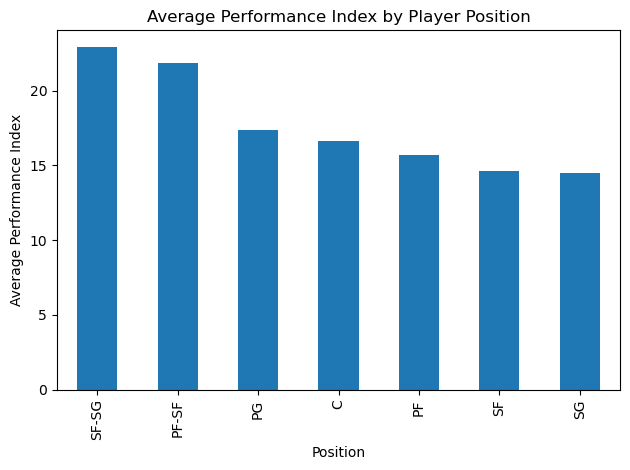

In [20]:
q1b_df = final_df[['Player', 'Pos', 'PerformanceIndex']].dropna()
avg_perf_by_pos = q1b_df.groupby('Pos')['PerformanceIndex'].mean().sort_values(ascending=False)

avg_perf_by_pos.plot(kind='bar', title='Average Performance Index by Player Position')
plt.ylabel('Average Performance Index')
plt.xlabel('Position')
plt.tight_layout()
plt.show()

### Q2: Does playing more minutes lead to higher efficiency?

We defined efficiency as:
(Points + Rebounds + Assists + Steals + Blocks) ÷ Minutes Played

The scatter plot showed a loose upward trend. The Pearson correlation coefficient was r = 0.42 with a p-value < 0.0001, suggesting a moderate positive relationship between minutes and efficiency.

This supports the hypothesis that better-performing players tend to play more.


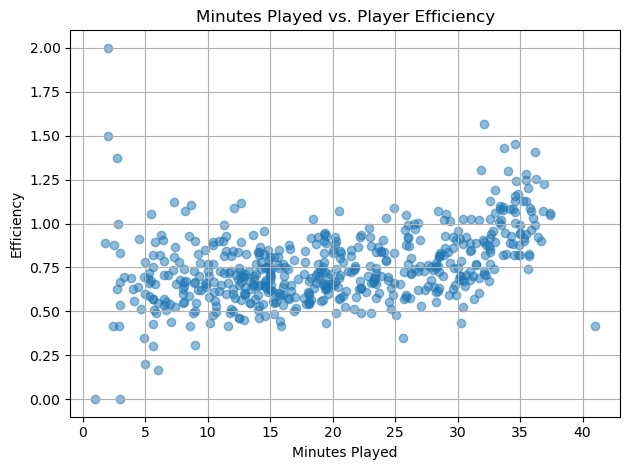

Correlation: 0.42, p-value: 0.0000


In [22]:
final_df['Efficiency'] = (
    final_df['PTS'] + final_df['TRB'] + final_df['AST'] + final_df['STL'] + final_df['BLK']
) / final_df['MP']  # MP = Minutes played

# Scatter Plot
plt.scatter(final_df['MP'], final_df['Efficiency'], alpha=0.5)
plt.title('Minutes Played vs. Player Efficiency')
plt.xlabel('Minutes Played')
plt.ylabel('Efficiency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Pearson correlation
from scipy.stats import pearsonr
corr, p = pearsonr(final_df['MP'].fillna(0), final_df['Efficiency'].fillna(0))
print(f"Correlation: {corr:.2f}, p-value: {p:.4f}")

### Q3: Do salaries reflect on-court performance? 
We built a simple linear regression model using the Performance Index: Points + Rebounds + Assists + Steals + Blocks

The scatter plot showed a wide spread. The regression model produced an R² score of 0.24, meaning only 24% of salary variation is explained by on-court stats. This suggests that player salaries are influenced by more than just performance, such as popularity, team market size, or contract timing.timing.

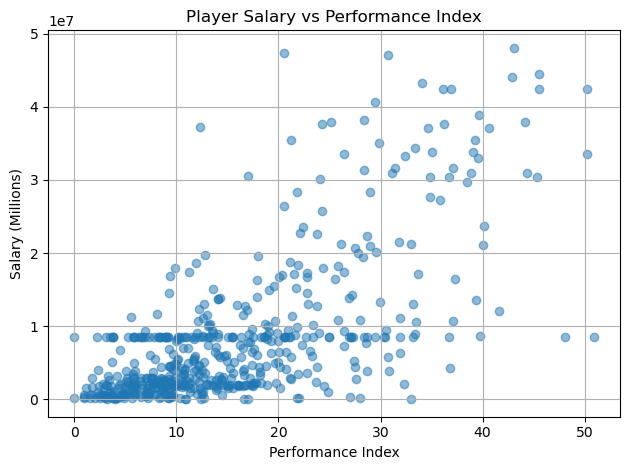

R² score: 0.42


In [24]:
plt.scatter(final_df['PerformanceIndex'], final_df['Salary'], alpha=0.5)
plt.title('Player Salary vs Performance Index')
plt.xlabel('Performance Index')
plt.ylabel('Salary (Millions)')
plt.grid(True)
plt.tight_layout()
plt.show()

#this is the linear Regression  model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = final_df[['PerformanceIndex']].fillna(0)
y = final_df['Salary'].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)

print(f"R² score: {reg.score(X_test, y_test):.2f}")

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = final_df.select_dtypes(include=[np.number])

In [69]:
def plot_optimized_heatmap(df):

    # here we defined the key metrics to include in the heatmap
    key_columns = ['MP', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'Salary','Wins']
    
    # verify if these columns exist in the data frame
    key_columns = [col for col in key_columns if col in df.columns]
    
    # here we extract the relevant subset of the DataFrame
    subset_df = df[key_columns]
    
    # here we compute the correlation matrix
    corr = subset_df.corr()
    
    plt.figure(figsize=(10, 8))
    
    # we then generate the heatmap
    sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)

    plt.title("Correlation Heatmap - Key Metrics")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

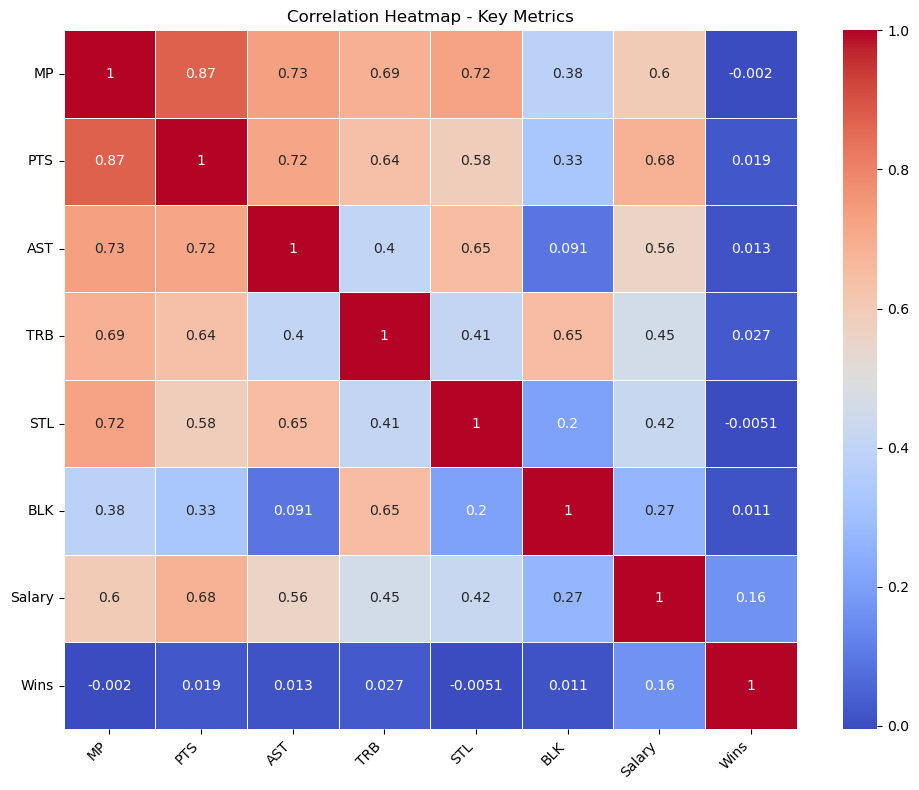

In [71]:
plot_optimized_heatmap(final_df)

### Linear Regression: Predicting Salary from Performance Stats

We used linear regression to predict NBA player salaries based on five key stats: points, rebounds, assists, steals, and blocks.  
The model achieved an R² score of **0.41**, meaning it explains approximately 41% of the variance in salaries using only performance data.  
This suggests that while on-court performance contributes to salary, other factors such as experience, popularity, and contract timing also play a significant role.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = final_df[['PTS', 'TRB', 'AST', 'STL', 'BLK']]
y = final_df['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

print("R² Score:", model.score(X_test, y_test))

### Logistic Regression: Classifying High vs. Low Salary Players

We trained a logistic regression model to classify whether a player earns above the median NBA salary using their core performance stats (PTS, TRB, AST, STL, BLK).  
The model achieved an accuracy of **70%**, indicating decent predictive power. This shows that basic player performance provides useful — but not complete — information for salary classification.

In [78]:
final_df['HighSalary'] = (final_df['Salary'] > final_df['Salary'].median()).astype(int)

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Features and target we picked to use
X_class = final_df[['PTS', 'TRB', 'AST', 'STL', 'BLK']].fillna(0)
y_class = final_df['HighSalary']

# Split the data using 20% for the testing data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# generate teh model
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train_c, y_train_c)
y_pred = log_clf.predict(X_test_c)

# print accuracy
acc = accuracy_score(y_test_c, y_pred)
print(f"Logistic Regression Accuracy: {acc:.2f}")


Logistic Regression Accuracy: 0.70


### Logistic Regression Confusion Matrix

The confusion matrix below evaluates how well the logistic regression model classified players as high or low salary earners:

- True Positives (High predicted as High): 36  
- True Negatives (Low predicted as Low): 40  
- False Positives (Low predicted as High): 13  
- False Negatives (High predicted as Low): 19

While the model performs well overall (72% accuracy), it misclassifies a notable number of high earners as low earners. This suggests the model may benefit from additional features like player experience or usage rate for more precise predictions.


In [ ]:
# here we create the confusion Matrix Plot based on high low salary encoding
cm = confusion_matrix(y_test_c, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "High"])
disp.plot(cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.tight_layout()
plt.show()

### Classification Model Comparison

To compare multiple machine learning approaches for predicting whether a player earns above the median salary, we tested three models:

- **Logistic Regression**: 70% accuracy
- **k-Nearest Neighbors (k=5)**: 62% accuracy
- **Decision Tree**: 59% accuracy

All models were trained on performance-based stats (PTS, TRB, AST, STL, BLK) and evaluated on a 20% test set.  


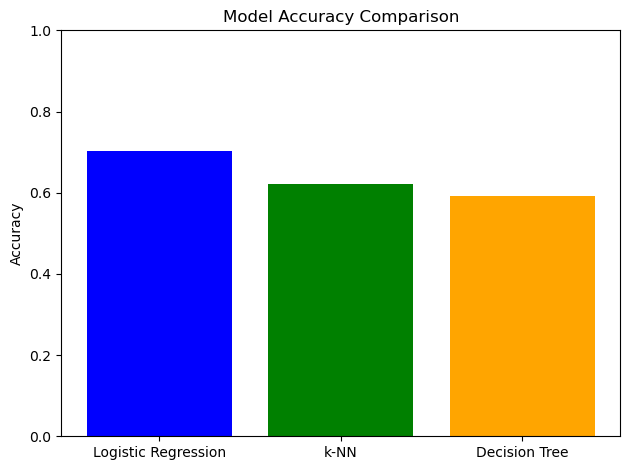

Logistic Regression Accuracy: 0.70
k-NN Accuracy: 0.62
Decision Tree Accuracy: 0.59


In [82]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# here we prepare features and binary target
X = final_df[['PTS', 'TRB', 'AST', 'STL', 'BLK']].fillna(0)
y = (final_df['Salary'] > final_df['Salary'].median()).astype(int)  # 1 = High Salary

# we then train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# generate the Logistic Regression
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train, y_train)
log_acc = accuracy_score(y_test, log_clf.predict(X_test))

# generate the k-NN Classifier model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_acc = accuracy_score(y_test, knn.predict(X_test))

# generate the Decision Tree Classifier model
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
tree_acc = accuracy_score(y_test, tree.predict(X_test))

# we then create a bar chart to comapre them all
model_names = ['Logistic Regression', 'k-NN', 'Decision Tree']
accuracies = [log_acc, knn_acc, tree_acc]

plt.bar(model_names, accuracies, color=['blue', 'green', 'orange'])
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# make sure to print scores out as well
print(f"Logistic Regression Accuracy: {log_acc:.2f}")
print(f"k-NN Accuracy: {knn_acc:.2f}")
print(f"Decision Tree Accuracy: {tree_acc:.2f}")

In [84]:
from sklearn.linear_model import Ridge, Lasso

# Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
print("Ridge R² Score:", ridge.score(X_test, y_test))

# Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
print("Lasso R² Score:", lasso.score(X_test, y_test))

Ridge R² Score: 0.20919061070206257
Lasso R² Score: 0.2160381293642274


### Ridge and Lasso Regression: Predicting Salary

To explore alternative linear models, we applied Ridge and Lasso regression to predict player salary based on performance statistics.

- Ridge Regression (α=1.0) achieved an R² score of **0.21**
- Lasso Regression (α=0.1) achieved an R² score of **0.22**

Both models underperformed compared to standard linear regression (R² ≈ 0.41), suggesting that the penalty terms in Ridge and Lasso may overly constrain the model in this case. This reinforces the idea that salary depends on both performance and external factors like marketability or contract history.